## Integrantes del grupo

- Jose Zamora
- Leandro Aroca
- Matthias Clein

## Librerías

In [100]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
from keras import models, optimizers, regularizers
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

## Cargar Datos

In [2]:
train_df = pd.read_csv("../MLA DB/data/train.csv")
test_df = pd.read_csv("../MLA DB/data/test.csv")
gs_df = pd.read_csv("../MLA DB/data/gender_submission.csv")

In [3]:
print(f"Dimensiones Train: {train_df.shape}")
print(f"Dimensiones Test: {test_df.shape}")
print(f"Dimensiones Gender Submission: {gs_df.shape}")

Dimensiones Train: (891, 12)
Dimensiones Test: (418, 11)
Dimensiones Gender Submission: (418, 2)


Agregamos la columna *Survived* del archivo *gender_submission* como columna *Survived* del DataFrame de *test*.

In [4]:
test_df["Survived"] = gs_df["Survived"]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


## Preprocesamiento de datos

### Eliminar columnas irrelevantes

Definimos que las columnas *PassengerId*, *Name*, *Ticket* y *Cabin* no aportan información relevante al modelo, además de que en algunos casos tienen una gran cantidad de valores nulos, por lo tanto las sacamos de los DataFrames.

In [7]:
train_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)
test_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
 7   Survived  418 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


Se aprecia que ambos DataFrames tienen valores nulos, principalmente en la feature de *Age*. 

### Rellenar datos faltantes

La columna *Embarked* de *train* se rellena con *S* (moda de la columna) y la columna *Fare* de *test* se rellena con la media de la columna.

In [10]:
# Train
train_df["Embarked"].fillna(value = train_df["Embarked"].mode().iloc[0], inplace = True)
# Test
test_df["Fare"].fillna(value = test_df["Fare"].mean(), inplace = True)

Se convierten las columnas categóricas (*Sex* y *Embarked*) a numéricas. 

In [11]:
encoder = LabelEncoder()
train_df["Sex"] = encoder.fit_transform(train_df["Sex"])
train_df["Embarked"] = encoder.fit_transform(train_df["Embarked"])
test_df["Sex"] = encoder.fit_transform(test_df["Sex"])
test_df["Embarked"] = encoder.fit_transform(test_df["Embarked"])

train_df = train_df.astype("float64")
test_df = test_df.astype("float64")

Rellenamos la columna *Age* con la media de valores considerados en base a *Survived*, *Sex* y *Cabin*.

In [12]:
def fill_age(dataframe):
    for s in range(0, 2):
        for c in range(1, 4):
            for g in range(0,2):
                mean = (dataframe.Age[(dataframe.Survived == s) & (dataframe.Pclass == c) & (dataframe.Sex == g)].mean())
                dataframe.loc[(dataframe.Age.isnull()) & (dataframe.Survived == s) & (dataframe.Pclass == c) & (dataframe.Sex == g), "Age"] = mean   
    dataframe.info()

In [13]:
fill_age(train_df)
fill_age(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
 7   Survi

### Reescalamiento de *features*

Reescalamos las edades y tarifas con RobustScaler para elimimar el efecto de los outliers.

In [14]:
def scale_age_fare(dataframe):
    Q1 = dataframe[["Age","Fare"]].quantile(0.25)
    Q3 = dataframe[["Age","Fare"]].quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    RS = RobustScaler(with_centering=False, with_scaling=True)
    dataframe[["Age","Fare"]] = RS.fit_transform(dataframe[["Age","Fare"]])

In [15]:
scale_age_fare(train_df)
print("-"*15)
scale_age_fare(test_df)

Age     15.0000
Fare    23.0896
dtype: float64
---------------
Age     13.3750
Fare    23.6042
dtype: float64


In [16]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,1.0,1.466667,1.0,0.0,0.313994,2.0
1,1.0,1.0,0.0,2.533333,1.0,0.0,3.087247,0.0
2,1.0,3.0,0.0,1.733333,0.0,0.0,0.343228,2.0
3,1.0,1.0,0.0,2.333333,1.0,0.0,2.299737,2.0
4,0.0,3.0,1.0,2.333333,0.0,0.0,0.348642,2.0


In [17]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3.0,1.0,2.579439,0.0,0.0,0.331687,1.0,0.0
1,3.0,0.0,3.514019,1.0,0.0,0.296557,2.0,1.0
2,2.0,1.0,4.635514,0.0,0.0,0.410414,1.0,0.0
3,3.0,1.0,2.018692,0.0,0.0,0.366990,2.0,0.0
4,3.0,0.0,1.644860,1.0,1.0,0.520564,2.0,1.0


### Definición de conjuntos de *train* y *test*

Definimos los conjuntos de *train* y *test* considerando los DataFrames ya preprocesado. Los *X* contendrán 7 columnas de *features* y los *Y* la etiqueta de clasificación.

In [18]:
X_train = train_df.drop(["Survived"], axis = 1)
y_train = train_df["Survived"]

X_test = test_df.drop(["Survived"], axis = 1)
y_test = test_df["Survived"]

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
dtypes: float64(7)
memory usage: 48.9 KB


In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    float64
 4   Parch     418 non-null    float64
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
dtypes: float64(7)
memory usage: 23.0 KB


### Normalización de valores

Ya armados los conjuntos *X* de *train* y *test*, procedemos a normalizar los valores de sus *features*. 

In [21]:
# min-max
def min_max_norm(dataframe):
    for column in dataframe.columns:    
        print(f"{column}-> min: {dataframe[column].min()} / max: {dataframe[column].max()}")
        dataframe[column] = (dataframe[column] - dataframe[column].min()) / (dataframe[column].max() - dataframe[column].min())

In [22]:
# maximum absolute
def max_abs_norm(dataframe):
    for column in dataframe.columns:
        dataframe[column] = dataframe[column]  / dataframe[column].abs().max()

Podemos ocupar las normalizaciones *min-max* o *maximum absolute*.

In [23]:
min_max_norm(X_train)
min_max_norm(X_test)
# max_abs_norm(X_train)
# max_abs_norm(X_test)

Pclass-> min: 1.0 / max: 3.0
Sex-> min: 0.0 / max: 1.0
Age-> min: 0.028 / max: 5.333333333333333
SibSp-> min: 0.0 / max: 8.0
Parch-> min: 0.0 / max: 6.0
Fare-> min: 0.0 / max: 22.1887429838542
Embarked-> min: 0.0 / max: 2.0
Pclass-> min: 1.0 / max: 3.0
Sex-> min: 0.0 / max: 1.0
Age-> min: 0.012710280373831777 / max: 5.682242990654205
SibSp-> min: 0.0 / max: 8.0
Parch-> min: 0.0 / max: 9.0
Fare-> min: 0.0 / max: 21.70500165224833
Embarked-> min: 0.0 / max: 2.0


In [24]:
X_train.shape

(891, 7)

In [25]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


In [26]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


## Modelo 1

El Modelo 1 se compone de:
- Capa de entrada con 32 neuronas y activación *relu*.
- Capa de Dropout de un 20%.
- Capa oculta de 32 neuronas y activación *relu*.
- Capa de Dropout de un 20%.
- Capa oculta de 32 neuronas y activación *relu*.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con learning rate: 0.01, 0.001 y 0.0001.

In [27]:
learning_rates = [0.01, 0.001, 0.0001]
model_1_list = []

for i in range(3):
    model = models.Sequential()
    model.add(Dense(input_shape = (7,), units = 32, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate = learning_rates[i]),
                metrics=['accuracy'])
    print(f"MODELO 1 con Learning Rate {learning_rates[i]}")
    # model.summary()
    history = model.fit(X_train,y_train, epochs = 300, batch_size = 16, validation_split = 0.2, verbose = 0)
    model_1_list.append(history)
    train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
    test_acc = model.evaluate(X_test, y_test, batch_size = 16)[1]
    print('Training accuracy: %s' % train_acc)
    print('Testing accuracy: %s' % test_acc)
    print("-"*100)
    

Metal device set to: Apple M1 Pro
MODELO 1 con Learning Rate 0.01


2022-11-21 19:43:23.915532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 19:43:23.915643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-21 19:43:24.050169: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-21 19:43:24.214452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:43:24.841272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 6ms/step - loss: 0.5122 - accuracy: 0.8038
Training accuracy: 0.8597082495689392
Testing accuracy: 0.8038278222084045
----------------------------------------------------------------------------------------------------
MODELO 1 con Learning Rate 0.001


2022-11-21 19:45:15.491500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:45:16.074044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 6ms/step - loss: 0.3697 - accuracy: 0.8086
Training accuracy: 0.8552188873291016
Testing accuracy: 0.8086124658584595
----------------------------------------------------------------------------------------------------
MODELO 1 con Learning Rate 0.0001


2022-11-21 19:47:06.563882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:47:07.208106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 6ms/step - loss: 0.2725 - accuracy: 0.9522
Training accuracy: 0.8159371614456177
Testing accuracy: 0.9521531462669373
----------------------------------------------------------------------------------------------------


## Modelo 2

El Modelo 2 se compone de:
- Capa de entrada con 32 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa oculta de 64 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa oculta de 64 neuronas, activación *elu* y regularización *L2*.
- Capa de Dropout de un 20%.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con learning rate: 0.01, 0.001 y 0.0001.

In [28]:
learning_rates = [0.01, 0.001, 0.0001]
model_2_list = []

for i in range(3):
    model2 = models.Sequential()
    model2.add(Dense(32, activation = "elu", input_shape = (7,), kernel_regularizer = regularizers.l2(0.001)))
    model2.add(Dropout(0.2))
    model2.add(Dense(64, activation = "elu", kernel_regularizer = regularizers.l2(0.001)))
    model2.add(Dropout(0.2))
    model2.add(Dense(64, activation = "elu", kernel_regularizer = regularizers.l2(0.001)))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, activation = "sigmoid"))
    model2.compile(optimizer = optimizers.Adam(learning_rate = learning_rates[i]), loss = "binary_crossentropy", metrics = "accuracy")
    print(f"MODELO 2 con Learning Rate {learning_rates[i]}")
    # model2.summary()
    history2 = model2.fit(X_train, y_train, epochs = 300, batch_size = 16, validation_split = 0.2, verbose = 0)
    model_2_list.append(history2)
    train_acc_2 = model2.evaluate(X_train, y_train, batch_size = 16)[1]
    test_acc_2 = model2.evaluate(X_test, y_test, batch_size = 16)[1]
    print('Training accuracy: %s' % train_acc_2)
    print('Testing accuracy: %s' % test_acc_2)
    print("-"*100)

MODELO 2 con Learning Rate 0.01


2022-11-21 19:48:52.927575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:48:54.159563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 15ms/step - loss: 0.3842 - accuracy: 0.9115
Training accuracy: 0.8181818723678589
Testing accuracy: 0.9114832878112793
----------------------------------------------------------------------------------------------------
MODELO 2 con Learning Rate 0.001


2022-11-21 19:53:46.372885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:53:47.615059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 14ms/step - loss: 0.3107 - accuracy: 0.9258
Training accuracy: 0.8136925101280212
Testing accuracy: 0.9258373975753784
----------------------------------------------------------------------------------------------------
MODELO 2 con Learning Rate 0.0001


2022-11-21 19:58:47.286749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 19:58:48.616706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 15ms/step - loss: 0.3370 - accuracy: 0.9354
Training accuracy: 0.8148148655891418
Testing accuracy: 0.9354067444801331
----------------------------------------------------------------------------------------------------


## Modelo 3

El Modelo 3 se compone de:
- Capa de entrada con 137 neuronas y activación *relu*.
- 10 capas ocultas con entre 210 y 220 neuronas con activación *relu*.
- Capas de Dropout de 50% cada 4 capas ocultas.
- Capa de salida con 1 neurona y activación *sigmoide*.
- Función de pérdida: *Binary Cross-Entropy*.
- Optimizador Adam con learning rate: 0.01, 0.001 y 0.0001.

In [29]:
learning_rates = [0.01, 0.001, 0.0001]
hidden_layers_sizes = 10
model_3_list = []

for i in range(3):
    model3 = models.Sequential()
    model3.add(Dense(137, activation = "relu", input_dim = X_train.shape[1]))
    for j in range(hidden_layers_sizes):
        model3.add(Dense((420 + j*2)//2, activation = "relu"))
        if (j%4 == 0):
            model3.add(Dropout(0.5))
    model3.add(Dense(1, activation = "sigmoid"))
    model3.compile(optimizer = optimizers.Adam(learning_rate = learning_rates[i]), loss = "binary_crossentropy", metrics = ["accuracy"])
    print(f"MODELO 3 con Learning Rate {learning_rates[i]}")
    # model3.summary()
    history3 = model3.fit(X_train, y_train, epochs = 300, batch_size = 200, validation_split = 0.2, verbose = 0)
    model_3_list.append(history3)
    train_acc_3 = model3.evaluate(X_train, y_train, batch_size = 16)[1]
    test_acc_3 = model3.evaluate(X_test, y_test, batch_size = 16)[1]
    print('Training accuracy: %s' % train_acc_3)
    print('Testing accuracy: %s' % test_acc_3)
    print("-"*100)

MODELO 3 con Learning Rate 0.01


2022-11-21 20:03:44.088799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:03:45.135257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 11ms/step - loss: 0.4144 - accuracy: 0.8732
Training accuracy: 0.8529742360115051
Testing accuracy: 0.8732057809829712
----------------------------------------------------------------------------------------------------
MODELO 3 con Learning Rate 0.001


2022-11-21 20:04:06.474958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:04:07.428479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 9ms/step - loss: 0.6727 - accuracy: 0.8278
Training accuracy: 0.8787879347801208
Testing accuracy: 0.8277512192726135
----------------------------------------------------------------------------------------------------
MODELO 3 con Learning Rate 0.0001


2022-11-21 20:04:28.610666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:04:29.535860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 10ms/step - loss: 0.3976 - accuracy: 0.8612
Training accuracy: 0.8552188873291016
Testing accuracy: 0.8612440824508667
----------------------------------------------------------------------------------------------------


## Comparación de resultados

Cada fila del gráfico presenta la curva de *accuracy* y *loss* de un modelo.

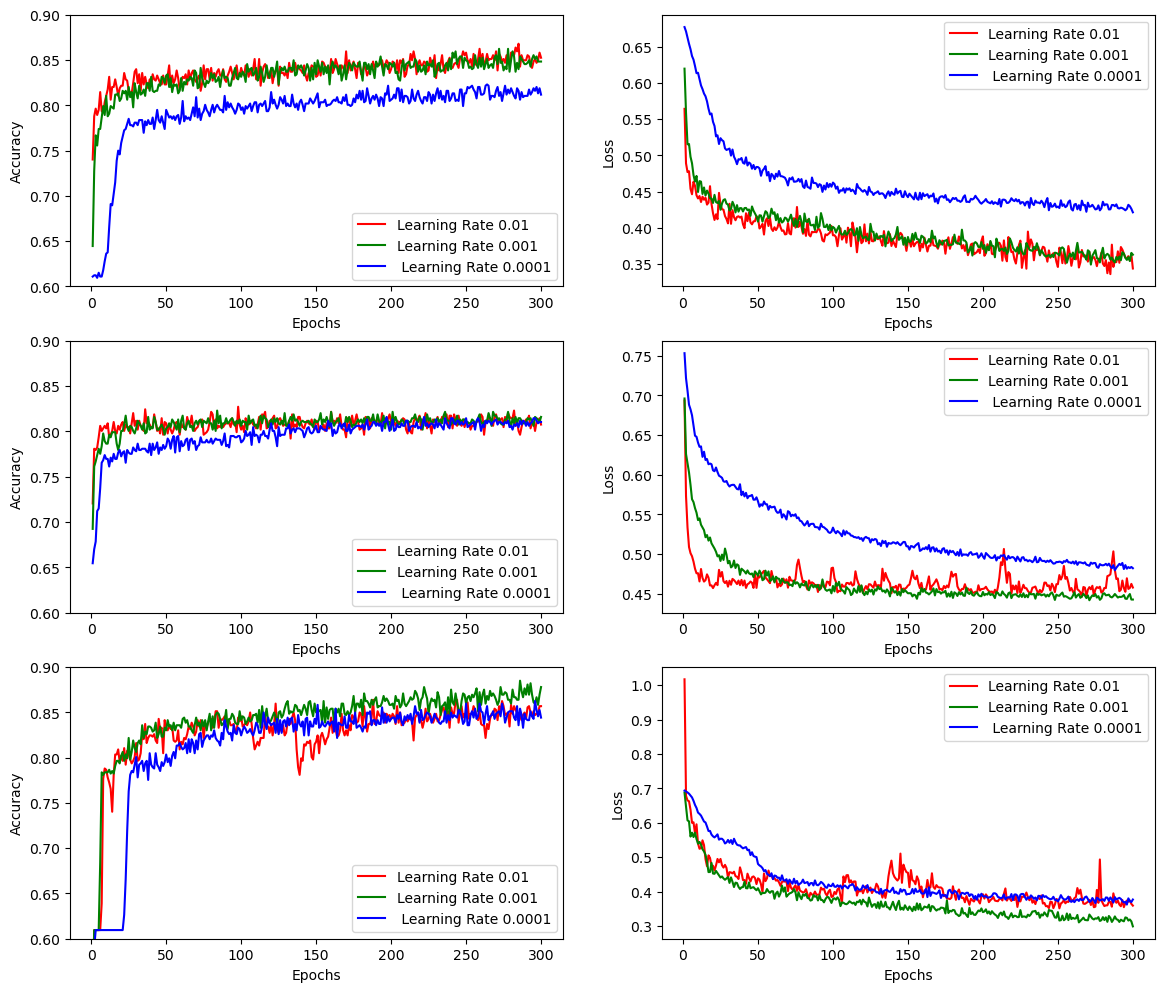

In [30]:
fig, ax = plt.subplots(3, 2, figsize = (14, 12))
epochs = range(1, len(model_1_list[0].history["accuracy"]) + 1)

accuracy_list_model_1 = [model_1_list[0].history["accuracy"], model_1_list[1].history["accuracy"], model_1_list[2].history["accuracy"]]
accuracy_list_model_2 = [model_2_list[0].history["accuracy"], model_2_list[1].history["accuracy"], model_2_list[2].history["accuracy"]]
accuracy_list_model_3 = [model_3_list[0].history["accuracy"], model_3_list[1].history["accuracy"], model_3_list[2].history["accuracy"]]

loss_values_list_model_1 = [model_1_list[0].history["loss"], model_1_list[1].history["loss"], model_1_list[2].history["loss"]]
loss_values_list_model_2 = [model_2_list[0].history["loss"], model_2_list[1].history["loss"], model_2_list[2].history["loss"]]
loss_values_list_model_3 = [model_3_list[0].history["loss"], model_3_list[1].history["loss"], model_3_list[2].history["loss"]]

accuracy_values = [accuracy_list_model_1, accuracy_list_model_2, accuracy_list_model_3]
loss_values = [loss_values_list_model_1, loss_values_list_model_2, loss_values_list_model_3]

colors = ["r", "g", "b"]
labels = ["Learning Rate 0.01", "Learning Rate 0.001", " Learning Rate 0.0001"]

for i in range(0, 3):
    for j in range(0, 3):
        ax[i][0].plot(epochs, accuracy_values[i][j], color = colors[j], label = labels[j])
        ax[i][1].plot(epochs, loss_values[i][j], color = colors[j], label = labels[j])
    ax[i][0].set_xlabel("Epochs")
    ax[i][0].set_ylabel("Accuracy")
    ax[i][1].set_xlabel("Epochs")
    ax[i][1].set_ylabel("Loss")
    ax[i][0].set_ylim(0.6, 0.9)
    ax[i][0].legend()
    ax[i][1].legend()
plt.show()

- No necesariamente aumenta el *accuracy* a medida que disminuye el valor del *learning rate*.
- Los *accuracy* obtenidos con *learning rate* 0.01 y 0.001 son muy similares.
- En los tres modelos se aprecia que a partir de aproximadamente la época 150 el *accuracy* y la *pérdida* no varían significativamente.
- En general el primer modelo es el que obtiene mayor *accuracy*, pero el mejor desempeño lo tuvo el modelo 3 con *learning rate* 0.001.

## Predicciones miembros del grupo

Cada integrante del grupo debe proporcionar la siguiente información:
- Pclass -> clase (1, 2, 3)
- Sex -> sexo
- Age -> edad
- SibSp -> hermanos
- Parch -> padres-hijos
- Fare -> tarifa (0 - 512)
- Embarked -> puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

In [31]:
data_grupo = {"Pclass": [1, 2, 2], 
    "Sex": ["male", "male", "male"], 
    "Age": [29, 32, 29], 
    "SibSp": [0, 4, 3], 
    "Parch": [2, 2, 0],
    "Fare": [400, 350, 200],
    "Embarked": ["Q", "S", "C"]
    }

grupo_df = pd.DataFrame(data = data_grupo)
grupo_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,29,0,2,400,Q
1,2,male,32,4,2,350,S
2,2,male,29,3,0,200,C


Se normalizarán los valores con respecto al set de entrenamiento:
- Pclass-> min: 1.0 / max: 3.0
- Sex-> min: 0.0 / max: 1.0
- Age-> dividir por 15.0000 / min: 0.028 / max: 5.333333333333333 
- SibSp-> min: 0.0 / max: 8.0
- Parch-> min: 0.0 / max: 6.0
- Fare-> dividir por 23.0896 / min: 0.0 / max: 22.1887429838542
- Embarked-> min: 0.0 / max: 2.0

In [32]:
mins = [1.0, 0.0, 0.028, 0.0, 0.0, 0.0, 0.0]
maxs = [3.0, 1.0, 5.333333333333333, 8.0, 6.0, 22.1887429838542, 2.0]

grupo_df["Sex"].replace(to_replace=["female", "male"], value=[0, 1], inplace = True)
grupo_df["Embarked"].replace(to_replace=["C", "Q", "S"], value=[0, 1, 2], inplace = True)
grupo_df = grupo_df.astype("float64")
grupo_df["Age"] = grupo_df["Age"] / 15.0000
grupo_df["Fare"] = grupo_df["Fare"] / 23.0896

for column, i in zip(grupo_df.columns, range(0, 7)):
    grupo_df[column] = (grupo_df[column] - mins[i]) / (maxs[i] - mins[i])

grupo_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,0.359135,0.000,0.333333,0.780748,0.5
1,0.5,1.0,0.396833,0.500,0.333333,0.683155,1.0
2,0.5,1.0,0.359135,0.375,0.000000,0.390374,0.0


Se utilizan los 3 modelos para realizar las predicciones:

In [90]:
models_preds = [model.predict(grupo_df, verbose = 0), 
                model2.predict(grupo_df, verbose = 0), 
                model3.predict(grupo_df, verbose = 0)]

for i in range(0, 3):
    print(f"---------- MODELO {i+1} ----------")
    print(f"Jose: {models_preds[i][0][0]}")
    print(f"Leandro: {models_preds[i][1][0]}")
    print(f"Matthias: {models_preds[i][2][0]}")
    print("-"*30)

---------- MODELO 1 ----------
Jose: 0.45678719878196716
Leandro: 0.10378417372703552
Matthias: 0.22569257020950317
------------------------------
---------- MODELO 2 ----------
Jose: 0.519282341003418
Leandro: 0.08679971843957901
Matthias: 0.23549281060695648
------------------------------
---------- MODELO 3 ----------
Jose: 0.199747696518898
Leandro: 0.05948347598314285
Matthias: 0.15021707117557526
------------------------------


Se genera un Dataframe con el resultado de los modelos y una media de estos para cada integrante.

In [175]:
modelo = []
for i in range(3):
    
    modelo.append(models_preds[i][0][0])
    modelo.append(models_preds[i][1][0])
    modelo.append(models_preds[i][2][0])
    
print("Presentacion de Resultados de los Modelos")
modelos = np.array(modelo)
modelos2 = modelos.reshape([3,3])
modelos = pd.DataFrame(modelos2, columns=["Modelo 1","Modelo 2", "Modelo 3"])
Mean = []
for i in range(3):
    Mean.append((modelos["Modelo 1"][i]+modelos["Modelo 2"][i]+modelos["Modelo 3"][i])/3)
modelos["Media Modelos"] = Mean
modelos["Integrantes"] = ["Jose","Leandro", "Matthias"]
modelos.set_index("Integrantes")

Presentacion de Resultados de los Modelos


,Modelo 1,Modelo 2,Modelo 3,Media Modelos
Integrantes,,,,
Jose,0.456787,0.103784,0.225693,0.262088
Leandro,0.519282,0.086800,0.235493,0.280525
Matthias,0.199748,0.059483,0.150217,0.136483
